# Problem Statement:  Social Media Monitoring for COVID-19 Insights using BERT



---



Imports and CUDA

In [2]:
import torch
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset, random_split
from torchvision import datasets, transforms
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import random
from tqdm.notebook import tqdm
from transformers import BertForSequenceClassification
from transformers import AutoTokenizer

# Check if CUDA (GPU) is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

d:\Data\udemy_python\venvp\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda


##  Step1: Dataset Overview

In [3]:
data = pd.read_csv('covid_twitter_dataset_codebasics_DL.csv')
data.head(5)

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [4]:
data.info()
data.target.value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5287 entries, 0 to 5286
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ID      5287 non-null   object
 1   text    5287 non-null   object
 2   target  5287 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 124.0+ KB


target
0    2746
1    2541
Name: count, dtype: int64



---



**Step2:** Split the dataset

* Train:Test :: 70:30



---



In [5]:
train_X, test_X, train_Y, test_Y = train_test_split( data['text'], data['target'], train_size=0.7, random_state=42)

**Step3:** Tokenization

* The AutoTokenizer from the Hugging Face library is used to load the pre-trained BERT tokenizer (bert-base-cased).


In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


In [7]:
train_tokens = tokenizer(list(train_X), padding = True, truncation=True)
test_tokens = tokenizer(list(test_X), padding = True, truncation=True)

In [8]:
train_tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [9]:
print(train_tokens['input_ids'][0])
print(tokenizer.decode(train_tokens['input_ids'][0]))

[101, 3725, 9216, 8653, 2740, 124, 5187, 1559, 5465, 1545, 1367, 5966, 1580, 9493, 2740, 122, 5539, 1571, 26516, 4859, 1545, 4735, 1116, 21606, 5117, 1477, 3993, 1604, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[CLS] Update Total cases 3 017 766 12 879 Current cases 1 915 580 856 Deaths 207 722 468 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]




---



**Step4**: Create a dataset class
* Implement a custom TokenData class inheriting from torch.utils.data.Dataset.
* Use the train argument to toggle between training (train_tokens, train_Y) and testing datasets (test_tokens, test_Y).
* Define __len__ to return the dataset length and __getitem__ to provide tokenized inputs (input_ids, attention_mask) and labels (labels) as tensors.
* Ensure the class works correctly by retrieving a sample and verifying the output format.

In [10]:
class TokenData(Dataset):
    def __init__(self, train = False):
        if train:
            self.text_data = train_X
            self.tokens = train_tokens
            self.labels = list(train_Y)
        else:
            self.text_data = test_X
            self.tokens = test_tokens
            self.labels = list(test_Y)

    def __len__(self):
            return len(self.text_data)

    def __getitem__(self, idx):
        sample = {}
        for k, v in self.tokens.items():
            sample[k] = torch.tensor(v[idx])
        sample['labels'] = torch.tensor(self.labels[idx])
        return sample



---



**Step5**: Create Dataloaders

* Initialize the `TokenData` class to create train_dataset and test_dataset objects for training and testing datasets.
* Set `batch_size=30` and enable shuffling for the training dataset to improve model generalization.
* Verify that train_loader and test_loader correctly return batches of tokenized inputs and labels.

In [11]:
batch_size = 30
train_dataset = TokenData(train=True)
test_dataset = TokenData(train=False)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



---



**Step6:** Define Model
*  Use `BertForSequenceClassification` with `bert-base-cased` to load a pre-trained BERT model for sequence classification tasks.
* Use `AdamW` optimizer with a learning rate of `1e-5` to fine-tune the model parameters. This optimizer is well-suited for transformer-based models.
* Use `CrossEntropyLoss` to compute the loss for multi-class classification (as the dataset contains two classes).

In [12]:
bert_model =  BertForSequenceClassification.from_pretrained('bert-base-cased')
optimizer = optim.Adam(bert_model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.




---



* num_eochs = 3
* Use bert_model.to(device) to move the model to a GPU if available, or keep it on the CPU. This ensures efficient computation, especially for large datasets or models like BERT.

In [13]:
num_epochs = 3
bert_model.to(device) # Transfer model to GPU if available

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e



---



**Step7:** Model Training

In [14]:
for epoch in range(num_epochs):
    bert_model.train()
    total_train_loss = 0.0  # Initialize total loss for each epoch

    for i, batch in enumerate(train_loader):
        batch = {k: v.to(device) for k, v in batch.items()}

        # Set gradients to zero
        optimizer.zero_grad()

        # Pass data to the model
        outputs = bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Get logits and calculate the loss
        labels = batch['labels']
        pred = outputs.logits
        loss = loss_fn(pred,labels)

        # Backpropagation
        loss.backward()

        # Optimizing model parameters
        optimizer.step()

        # Accumulate the loss for the epoch
        total_train_loss += loss.item()

    # Calculate and log the average loss for the epoch
    avg_train_loss = total_train_loss / len(train_loader)
    print(f"Epoch {epoch + 1}/{num_epochs} - Training Loss: {avg_train_loss:.4f}")


Epoch 1/3 - Training Loss: 0.4413
Epoch 2/3 - Training Loss: 0.2082
Epoch 3/3 - Training Loss: 0.1265




---



**Step8:** Model Evaluation

In [15]:
# Set model to evaluation mode
bert_model.eval()

# Variables for tracking accuracy and loss
correct = 0
total = 0
total_test_loss = 0.0
all_preds = []
all_labels = []

# Disable gradient computation during testing
with torch.no_grad():
    for batch in test_loader:
        batch = {k: v.to(device) for k, v in batch.items()}

        # Forward pass
        outputs = bert_model(input_ids=batch['input_ids'], attention_mask=batch['attention_mask'])

        # Get logits
        logits = outputs.logits

        # Calculate loss
        labels = batch['labels']
        loss = loss_fn(logits,labels)
        total_test_loss += loss.item()

        # Get predictions
        preds = logits.argmax(dim=1)

        # Update the correct count and total number of samples
        correct += (preds == batch['labels']).sum().item()
        total += batch['labels'].size(0)

        # Store predictions and labels for confusion matrix
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch['labels'].cpu().numpy())

# Calculate the average test loss
avg_test_loss = total_test_loss / len(test_loader)

# Calculate overall accuracy
accuracy = (correct / total) * 100

# Print overall results
print(f"Test Set - Loss: {avg_test_loss:.4f}, Accuracy: {accuracy:.2f}%")

Test Set - Loss: 0.2564, Accuracy: 90.17%


## Visualize the Confusion Matrix

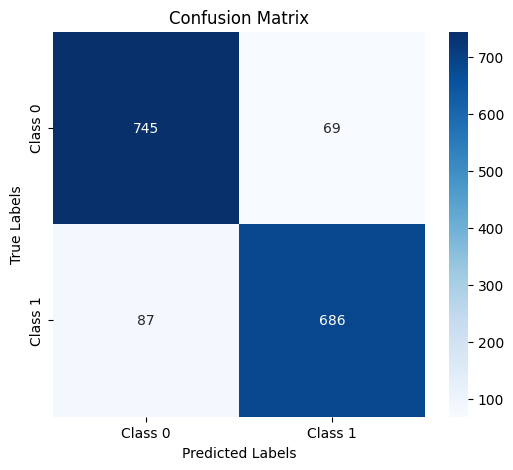

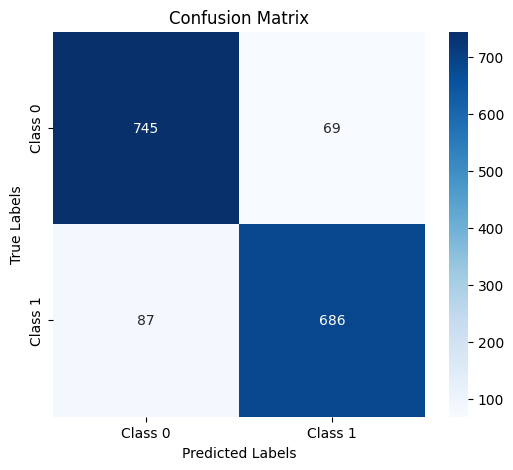

In [16]:
import seaborn as sns

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Compute the confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()




---



**Step9**: Inference with new Tweets

* Run this inference code to predict the output for test_tweets

In [ ]:
# Test tweets
test_tweets = [
    "The football match last night was absolutely thrilling!",
    "Vaccination centers are working overtime to meet demand.",
    "Can't believe my favorite artist is coming to my city for a concert!",
    "WHO recommends wearing masks in crowded places to prevent the spread of COVID-19.",
    "The stock market saw a major rise today with tech companies leading the way."
]

# Predict function for a single tweet
def predict_tweet(tweet_text):
    # Tokenize
    tokens = tokenizer(tweet_text, padding=True, truncation=True, return_tensors='pt')
    tokens = {k: v.to(device) for k, v in tokens.items()}

    # Predict
    bert_model.eval()
    with torch.no_grad():
        outputs = bert_model(**tokens)
        probs = torch.softmax(outputs.logits, dim=1)
        prediction = torch.argmax(probs, dim=1)

    return {
        'text': tweet_text,
        'is_covid': bool(prediction.item()),
        'confidence': probs[0][prediction[0]].item() * 100
    }

# Make predictions for test tweets
def final_predic():
    print("Sample Tweet Predictions:\n")
    for tweet in test_tweets:
        result = predict_tweet(tweet)
        print(f"Tweet: {result['text']}")
        print(f"Prediction: {'COVID-related' if result['is_covid'] else 'Not COVID-related'}")
        print(f"Confidence: {result['confidence']:.2f}%")
        print("-" * 50 + "\n")

In [21]:
final_predic()

Sample Tweet Predictions:

Tweet: The number of COVID-19 cases is rising again in several countries.
Prediction: COVID-related
Confidence: 99.08%
--------------------------------------------------

Tweet: The football match last night was absolutely thrilling!
Prediction: Not COVID-related
Confidence: 96.30%
--------------------------------------------------

Tweet: Vaccination centers are working overtime to meet demand.
Prediction: COVID-related
Confidence: 98.77%
--------------------------------------------------

Tweet: Can't believe my favorite artist is coming to my city for a concert!
Prediction: Not COVID-related
Confidence: 55.49%
--------------------------------------------------

Tweet: WHO recommends wearing masks in crowded places to prevent the spread of COVID-19.
Prediction: COVID-related
Confidence: 98.81%
--------------------------------------------------

Tweet: The stock market saw a major rise today with tech companies leading the way.
Prediction: COVID-related
Conf

In [22]:
test_tweets = [
"Wearing a mask helps reduce the spread of airborne diseases like COVID-19 and the flu.",
"I'm feeling sick today. I hope it's just a normal flu and not COVID!",
"The NBA game had a reduced audience due to pandemic restrictions.",
"More companies are allowing work-from-home options post-pandemic.",
"Travel restrictions have been eased, but vaccination proof is still required.",
]
final_predic()

Sample Tweet Predictions:

Tweet: Wearing a mask helps reduce the spread of airborne diseases like COVID-19 and the flu.
Prediction: COVID-related
Confidence: 98.75%
--------------------------------------------------

Tweet: I'm feeling sick today. I hope it's just a normal flu and not COVID!
Prediction: COVID-related
Confidence: 63.24%
--------------------------------------------------

Tweet: The NBA game had a reduced audience due to pandemic restrictions.
Prediction: COVID-related
Confidence: 73.16%
--------------------------------------------------

Tweet: More companies are allowing work-from-home options post-pandemic.
Prediction: COVID-related
Confidence: 98.96%
--------------------------------------------------

Tweet: Travel restrictions have been eased, but vaccination proof is still required.
Prediction: COVID-related
Confidence: 98.10%
--------------------------------------------------



## Thank you